In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import math as m
from scipy.stats import pearsonr

In [3]:
inflation = pd.read_csv('Price_index.csv',index_col = 0)

inflation.columns = ['price']
inflation['delta'] = ((inflation['price'] - inflation['price'].shift(12))/inflation['price']) * 100
inflation = inflation.loc['1976-01-01':'2017-03-01']
#print(inflation)

difference = pd.read_csv('M2_less_small_time_deposits.csv', index_col = 0)
difference.columns = ['M2_less_deposits']
difference['M2_less_deposits'] = difference['M2_less_deposits'] / 1000

delta_difference = ((difference['M2_less_deposits'] - difference['M2_less_deposits'].shift(12))/difference['M2_less_deposits']) * 100

delta_difference = pd.DataFrame(delta_difference)
delta_difference = delta_difference.loc['1976-01-01':'2017-03-01']


## Je m'assure du type de données ##
inflation.astype(dtype = 'float')
delta_difference.astype(dtype = 'float')

delta_difference.columns=['M2_less_deposits']

<Figure size 432x288 with 0 Axes>

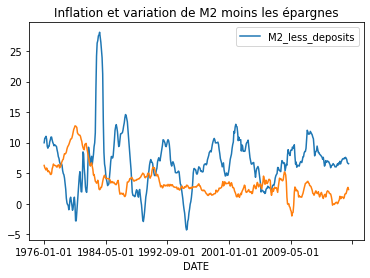

In [4]:
plt.figure()
delta_difference.plot()
inflation['delta'].plot()
plt.title('Inflation et variation de M2 moins les épargnes')
plt.show()

In [5]:
############# Analyse statistique de base #############

## inlfation et delta différence entre 1976 et 2017 ##

x1 = inflation['delta'].values
y1 = delta_difference['M2_less_deposits'].values

from scipy.stats import pearsonr
coeff_pearson = pearsonr(x1,y1)
print("coefficient de Pearson = {}".format(coeff_pearson))

coefficient de Pearson = (-0.3209040420970541, 2.5549527247277276e-13)


<Figure size 432x288 with 0 Axes>

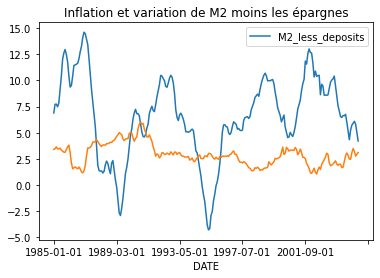

In [6]:
## inlfation et delta différence entre 1985 et 2005 ##

delta_difference_1985 = delta_difference.loc['1985-01-01':'2005-03-01']
inflation_1985 = inflation.loc['1985-01-01':'2005-03-01']

plt.figure()
delta_difference_1985.plot()
inflation_1985['delta'].plot()
plt.title('Inflation et variation de M2 moins les épargnes')
plt.show()

In [7]:
############# Analyse statistique de base #############

x2 = inflation_1985['delta'].values
y2 = delta_difference_1985['M2_less_deposits'].values

from scipy.stats import pearsonr
coeff_pearson = pearsonr(x2,y2)
print("coefficient de Pearson après 1985 = {}".format(coeff_pearson))

coefficient de Pearson après 1985 = (-0.44709365183487226, 2.413011954227127e-13)


# Étude Tau linéaire

In [8]:
def T(a,b,x):
    return a*x+b

## Étude de tau sur les séries standardisées

In [9]:
## Je vais utiliser les dataframe de 1983 à 2007 pour être large puis je vais couper entre 1983 et 2001

delta_difference_1983_2001_standard = delta_difference.loc['1983-01-01':'2001-03-01']
inflation_1983_2007 = inflation.loc['1983-01-01':'2007-03-01']

scaler = StandardScaler()

In [10]:
### Construction du T idéal ###

values = delta_difference_1983_2001_standard['M2_less_deposits'].values
values = values.reshape((len(values), 1))
scaler = scaler.fit(values)
delta_difference_1983_2001_standard['M2_less_deposits'] = scaler.transform(values) # Standardisation de M

inflation_1983_2007_values = inflation_1983_2007['delta'].values # Préparer les données

delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard['M2_less_deposits'].values # Préparer les données
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.reshape((len(values), 1))
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.tolist()

for j in range(len(delta_difference_1983_2001_standard_values)):     
            delta_difference_1983_2001_standard_values[j] = delta_difference_1983_2001_standard_values[j][0]  # Mise au bon format

R_best_standard = 0
Solution_ideale_standard = [0,0,0]
Meilleurs_solutions_standard = []
inflation_shift_ideale_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]

A = [0.005*i for i in range(0,31)]

for a in A:

    for b in range(0,37):
        infla_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]

        for i in range(len(delta_difference_1983_2001_standard_values)):
            shift = T(a,b,i)
            beta = m.floor(shift)
            alpha = shift - beta
            infla_standard[i] = (1-alpha)*inflation_1983_2007_values[i+beta] + alpha*inflation_1983_2007_values[i+beta+1]

        values = np.array(infla_standard)
        values = values.reshape((len(values), 1))
        scaler = scaler.fit(values)
        infla_standard = scaler.transform(values) #Standardisation de infla_standard
        infla_standard = infla_standard.tolist()

        for j in range(len(infla_standard)) :     # Mise au bon format
            infla_standard[j] = infla_standard[j][0]

        R = pearsonr(infla_standard,delta_difference_1983_2001_standard_values)
        
        if abs(R[0]) > 0.34 :
            Meilleurs_solutions_standard.append([a,b,R])

        if abs(R[0]) > abs(R_best_standard) :
            Solution_ideale_standard = [a,b,R]
            R_best_standard = R[0]
            inflation_shift_ideale_standard = infla_standard


print(Solution_ideale_standard)
print(Meilleurs_solutions_standard)

<ipython-input-10-71d5fff1459e>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_difference_1983_2001_standard['M2_less_deposits'] = scaler.transform(values) # Standardisation de M
[0.0, 0, (-0.2634312650895862, 7.945330776083755e-05)]
[]


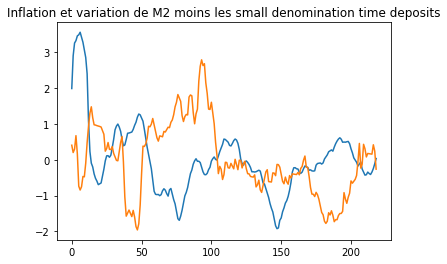

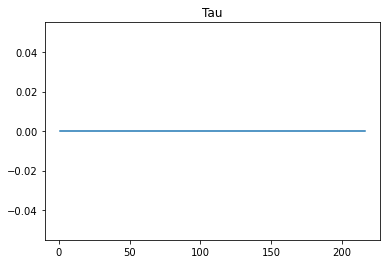

In [12]:
plt.figure()
plt.plot(delta_difference_1983_2001_standard_values,label='M')
plt.plot(inflation_shift_ideale_standard,label='inflation')
plt.title('Inflation et variation de M2 moins les small denomination time deposits')

plt.figure()
X=[x for x in range(1,217)]
Y = []
for x in X:
    Y.append(T(0,0,x))
plt.plot(X,Y)
plt.title('Tau')
plt.show()

# Étude avec Tau log

## Étude sur les séries standardisées

In [13]:
def T(a,b,x):
    return(12*(m.log(a*x+b)))

In [14]:
###### Standardization de la série temporelle ######

## Je vais utiliser les dataframe de 1981 à 2007 pour être large puis je vais couper entre 1983 et 2001

delta_difference_1983_2001_standard = delta_difference.loc['1983-01-01':'2001-03-01']
inflation_1983_2007 = inflation.loc['1983-01-01':'2007-03-01']

scaler = StandardScaler()

In [15]:
### Construction du T idéal ###

values = delta_difference_1983_2001_standard['M2_less_deposits'].values
values = values.reshape((len(values), 1))
scaler = scaler.fit(values)
delta_difference_1983_2001_standard['M2_less_deposits'] = scaler.transform(values) # Standardisation de M

inflation_1983_2007_values = inflation_1983_2007['delta'].values # Préparer les données

delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard['M2_less_deposits'].values # Préparer les données
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.reshape((len(values), 1))
delta_difference_1983_2001_standard_values = delta_difference_1983_2001_standard_values.tolist()

for j in range(len(delta_difference_1983_2001_standard_values)):     
            delta_difference_1983_2001_standard_values[j] = delta_difference_1983_2001_standard_values[j][0]  # Mise au bon format

R_best_standard = 0
Solution_ideale_standard = [0,0,0]
Meilleurs_solutions_standard = []
inflation_shift_ideale_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]

A = [0.001*i for i in range(1,101)]
B = [0.5*i for i in range(2,41)]

for a in A:

    for b in B:
        infla_standard = [0 for x in range(len(delta_difference_1983_2001_standard_values))]
        for i in range(len(delta_difference_1983_2001_standard_values)):
            shift = T(a,b,i)
            beta = m.floor(shift)
            alpha = shift - beta
            infla_standard[i] = (1-alpha)*inflation_1983_2007_values[i+beta] + alpha*inflation_1983_2007_values[i+beta+1]

        values = np.array(infla_standard)
        values = values.reshape((len(values), 1))
        scaler = scaler.fit(values)
        infla_standard = scaler.transform(values) #Standardisation de infla_standard
        infla_standard = infla_standard.tolist()

        for j in range(len(infla_standard)) :     # Mise au bon format
            infla_standard[j] = infla_standard[j][0]

        R = pearsonr(infla_standard,delta_difference_1983_2001_standard_values)
        
        if abs(R[0]) > 0.4 :
            Meilleurs_solutions_standard.append([a,b,R])

        if abs(R[0]) > abs(R_best_standard) :
            Solution_ideale_standard = [a,b,R]
            R_best_standard = R[0]
            inflation_shift_ideale_standard = infla_standard


print(Solution_ideale_standard)
print(R_best_standard)
print(Meilleurs_solutions_standard)

<ipython-input-15-713672e90de2>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  delta_difference_1983_2001_standard['M2_less_deposits'] = scaler.transform(values) # Standardisation de M
[0.1, 3.5, (0.2639968395588367, 7.658961144425472e-05)]
0.2639968395588367
[]


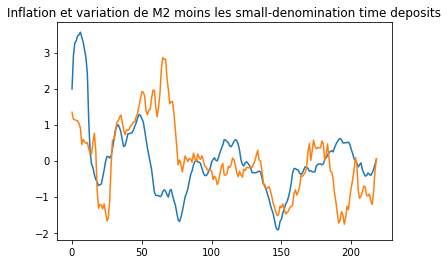

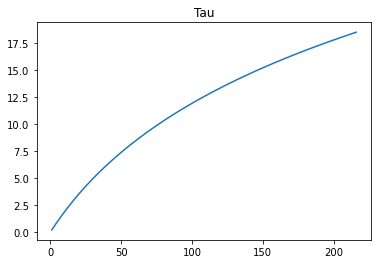

In [16]:
plt.figure()
plt.plot(delta_difference_1983_2001_standard_values,label='M')
plt.plot(inflation_shift_ideale_standard,label='inflation')
plt.title('Inflation et variation de M2 moins les small-denomination time deposits')

plt.figure()
X=[x for x in range(1,217)]
Y = []
for x in X:
    Y.append(T(0.017,1,x))
plt.plot(X,Y)
plt.title('Tau')
plt.show()